In [3]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [4]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])



# Initialize the content scene

In [5]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)
content_scene = Scene(dataset, content_gaussians, shuffle=True)
content_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [6]:
content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog/chkpnt30000.pth")[0], opt)


In [7]:
content_gaussians_features_dc_orig = content_gaussians._features_dc.data.detach().clone()
content_gaussians_features_rest_orig = content_gaussians._features_rest.data.detach().clone()


In [8]:
# Turn color into coordinates. We will need that to optimize 
# Remove view dependent effects and make all the gaussians opaque. 
# That helps with getting a better mesh
content_gaussians._opacity.data +=  1e6
content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.
# content_gaussians._scaling.data *=  .98


In [9]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



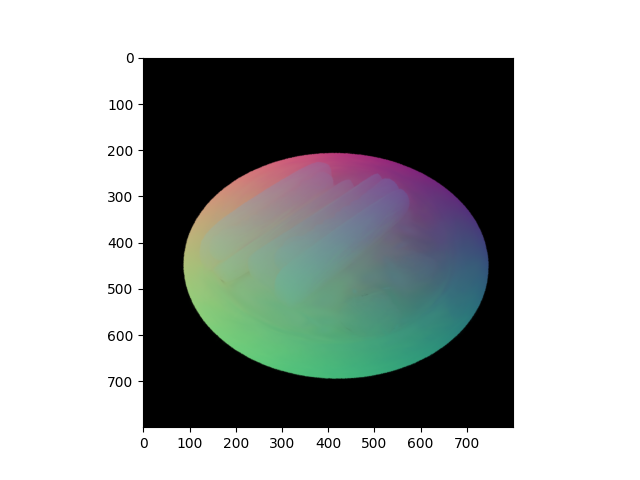

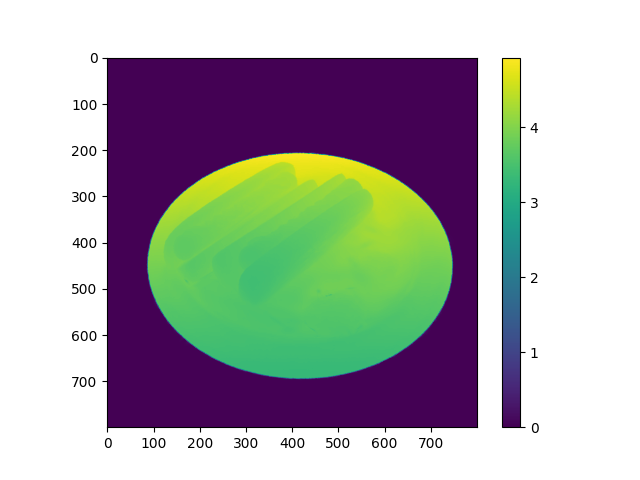

In [10]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


# Init surface and find better initialization points.

In [11]:

def obtain_surface_pc(viewpoint_stack, gaussians, pipe, background, num_viewpoints=40, pc_size=20000):
    import numpy as np
    import skimage.measure, skimage.morphology
    import scipy

    # 1. Render from different viewpoints and extract points
    all_points = []
    for iter in range(min(num_viewpoints, len(viewpoint_stack))):
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        render_pkg_cont = render(viewpoint_cam, gaussians, pipe, background)
        image = render_pkg_cont["render"]
        image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
        image_maxpool = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)
        mask = scipy.ndimage.binary_erosion(np.max(image_maxpool, axis=-1) > 0.1, structure=None, iterations=5)
        image_clean = image_maxpool * np.expand_dims(mask, axis=-1)
        all_points += list(image_clean[np.min(image_clean, axis=-1)>0.1])
    
    
    # 2. Subsample the points 
    all_points = np.array(all_points)
    all_points_idcs = np.random.choice(range(len(all_points)), size=pc_size, replace=False) 
    all_points = all_points[all_points_idcs]

    # 3. Remove poitns that are too far away from all other points.
    # Compute all pairwise distances between points
    from scipy.spatial import distance
    k=10
    pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
    # Use np.partition to find the k-th smallest distances for each row
    kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
    kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
    q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.99)
    idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
    all_points = all_points[idcs]
    return all_points
        

In [12]:

content_surface_pc = obtain_surface_pc(viewpoint_stack=viewpoint_stack, 
                               gaussians=content_gaussians, 
                               pipe=pipe, 
                               background=background,
                               num_viewpoints=40)
# Rescale back. This can be a very wrong way to do that. Check better the rasterization code for 
content_surface_pc_orig = np.array(content_surface_pc)
coords = content_gaussians._xyz.data.detach().cpu().numpy()
content_surface_pc = (content_surface_pc - np.min(content_surface_pc)) / (np.max(content_surface_pc)  - np.min(content_surface_pc))
content_surface_pc = content_surface_pc * (np.max(coords)  - np.min(coords)) + np.min(coords)

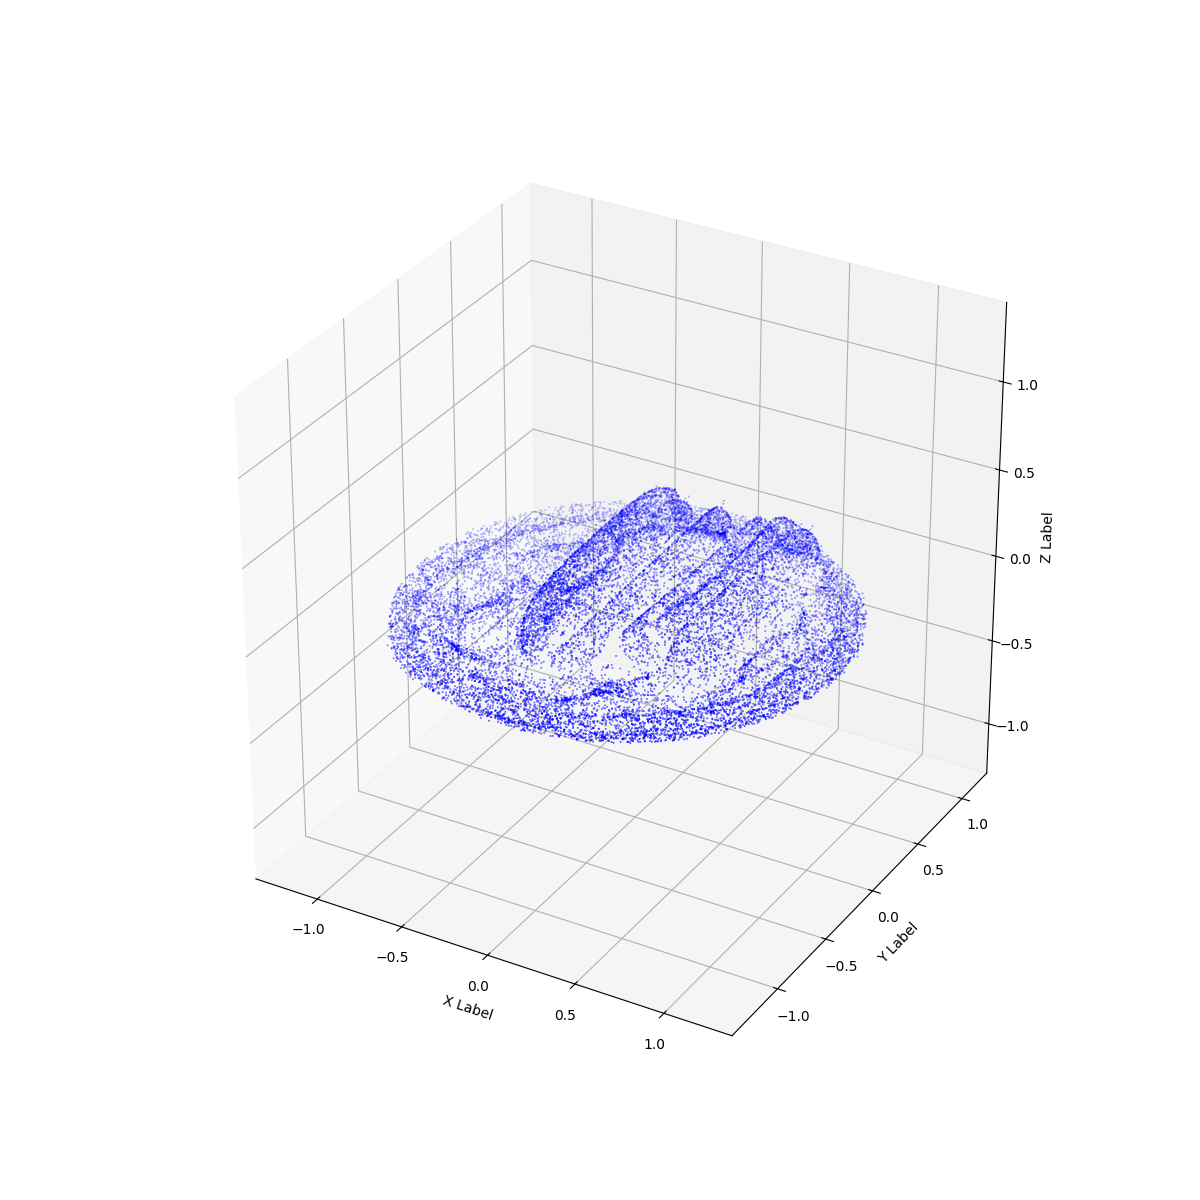

In [13]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    ax.scatter(content_surface_pc[::kth,0], 
               content_surface_pc[::kth,1], 
               content_surface_pc[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [14]:
# Load cluster of style and prepare it 

In [15]:

loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14
loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_rose_bush_spheres_clusters_30/cluster_12.npz")
#loaded_data = np.load("/home/dimakot55/output_data/clusters/GT_coast_rocks_spheres_clusters=50/cluster_15.npz")
# loaded_data = np.load("/home/dimakot55/output_data/clusters/GT_grass_spheres_clusters=4/cluster_1.npz")

# loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_brickwall_spheres_clusters_50/cluster_14.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

# 0. only for the bricks scene. Remove poitns underneath. and change size to smaller scale. Multiply coordinates and sizes.
idcs = np.where(gaussians_xyz[:,2]>-0.12)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]




# 1. Remove poitns that are too far away from all other points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.9925) # was 0.925
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)


# Extra increase the volume of the points to make results more apparent
with torch.no_grad():
    # gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for lego
    gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.0 # for bricks 

[   0    1    2 ... 9921 9922 9923]


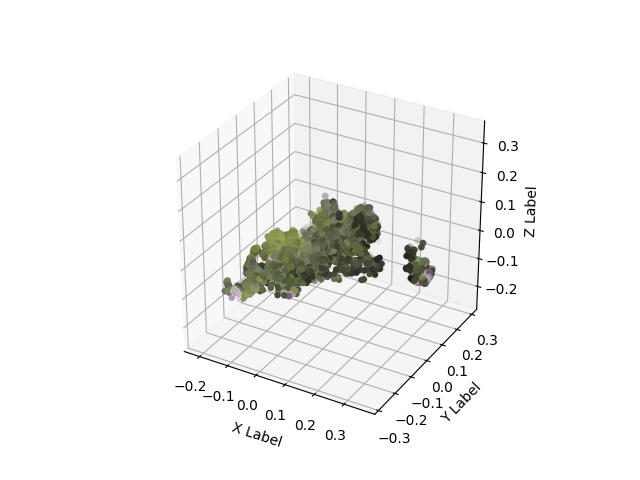

In [16]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
idcs = np.where(gaussians_xyz[:,2]>-0.25)[0]
print(idcs)
ax.scatter(gaussians_xyz[idcs,0], 
           gaussians_xyz[idcs,1], 
           gaussians_xyz[idcs,2],#*1.5, 
           c=np.concatenate([colors, alpha[:,None]], axis=-1)[idcs],# c='b', 
           marker='o',
           s=sizes[idcs], #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()





In [17]:
import kornia
def shade_image_gpu(img_color, img_depth,
                drct_lght_color = np.array([1., 1., 1.]), drct_lght_dir = np.array([0., 0., 1.]),
                ambnt_lght=np.array([0.1, 0.1, 0.1]) ):
    """
    Relights the image given by the color of every pixel and its normals. Additionally use the sf
    Implementation is taken from this video https://youtu.be/wOyavGx28uU?t=1084 .
    :param img_color: numpy array of shape [H,W,D] with values in [0,1]
    :param img_normals: numpy array of shape [H,W,D] with values in [0,1] and norm along last dim is 1
    :param 
    
    """

     
    K = torch.tensor([[1111, 0, 400],
                      [0,    1111, 400],
                      [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
    normals = kornia.geometry.depth.depth_to_normals(depth=img_depth.unsqueeze(0).unsqueeze(0),
                                                     camera_matrix=K,
                                                     normalize_points=True)
    #normals

    #print(normals)
    #print(normals[0].shape)
    image_normals = normals.squeeze(0).squeeze(0)
    #print(image_normals.shape)
    mins = torch.min(image_normals)
    maxs = torch.max(image_normals)
    image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
    # image_normals = normals.squeeze(0).squeeze(0)
    
    drct_lght_color = drct_lght_color.unsqueeze(-1).unsqueeze(-1)
    ambnt_lght = ambnt_lght.unsqueeze(-1).unsqueeze(-1)
    drct_lght_dir = drct_lght_dir / (1e-6 + torch.linalg.norm(drct_lght_dir))
    #print("drct_lght_color.shape:", drct_lght_color.shape)
    #print("image_normals.shape:", image_normals.shape)
    #print("drct_lght_dir.shape:", drct_lght_dir.shape)
    #print("ambnt_lght.shape:", ambnt_lght.shape)
    #print(torch.einsum('ihw,i->hw', image_normals, drct_lght_dir))
    reflected_light = drct_lght_color * (torch.clamp(torch.einsum('ihw,i->hw', image_normals, drct_lght_dir), 0.,1.).unsqueeze(0))
    #print("reflected_light.shape:", reflected_light.shape)
    color =  img_color * torch.clamp((reflected_light*(1.-torch.max(ambnt_lght))+ambnt_lght), 0., 1.)
    return color 


In [18]:
gaussians_opt = GaussianModel(3)#.to(device="cuda")
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [20]:
#np.random.choice(range(len(all_points)), size=50000, replace=False) 
#content_surface_pc = all_points[all_points_idcs]

idcs = np.random.choice(len(content_surface_pc), size=40, replace=False)
content_shape_cluster_centers  = content_surface_pc[idcs]

                                                 

In [21]:
C = len(content_shape_cluster_centers)
gaussians_opt._features_dc.data = torch.concat([torch.tensor(gaussians_features_dc)]*C).to(device=device)
gaussians_opt._features_rest.data = torch.concat([torch.tensor(gaussians_features_rest)*1.]*C).to(device=device)
gaussians_opt._rotation.data = torch.concat([torch.tensor(gaussians_rotation)]*C).to(device=device)
gaussians_opt._scaling.data = torch.concat([torch.tensor(gaussians_scaling)]*C).to(device=device)
gaussians_opt._opacity.data = torch.concat([torch.tensor(gaussians_opacity)]*C).to(device=device)

N = len(gaussians_xyz)
gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:N])]*C).to(device=device)
gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:N])]*C).to(device=device)
gaussians_opt.denom.data = torch.concat([torch.tensor(content_gaussians.denom[:N])]*C).to(device=device)


/tmp/ipykernel_129630/2882836945.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:N])]*C).to(device=device)
/tmp/ipykernel_129630/2882836945.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:N])]*C).to(device=device)
/tmp/ipykernel_129630/2882836945.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.denom.data = torch.concat

In [22]:
gaussians_opt_features_dc_original = gaussians_opt._features_dc.data.detach().clone()
gaussians_opt_features_rest_original = gaussians_opt._features_rest.data.detach().clone()

gaussians_opt._xyz.data = torch.concat([torch.tensor( (gaussians_xyz - np.mean(gaussians_xyz, axis=0))*1. + cluster_center).to(device=device) 
                                          for cluster_center in content_shape_cluster_centers])

In [23]:

with torch.no_grad():
    gaussians_opt._features_dc.data = gaussians_opt._xyz.data.clone().detach().unsqueeze(1)
    gaussians_opt._features_rest.data = gaussians_opt._features_rest.data * 0.

In [151]:
colors = torch.nn.Parameter(torch.randn((C,3), dtype=torch.float32))
colors_gaussians = torch.concat([torch.stack([x]*N, dim=0) for x in colors], dim=0).unsqueeze(1).to(device=device)
gaussians_opt._features_dc.data = gaussians_opt._features_dc.data + colors_gaussians.data

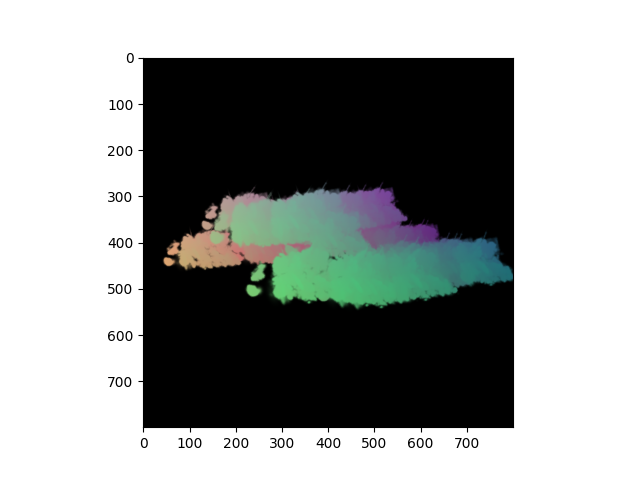

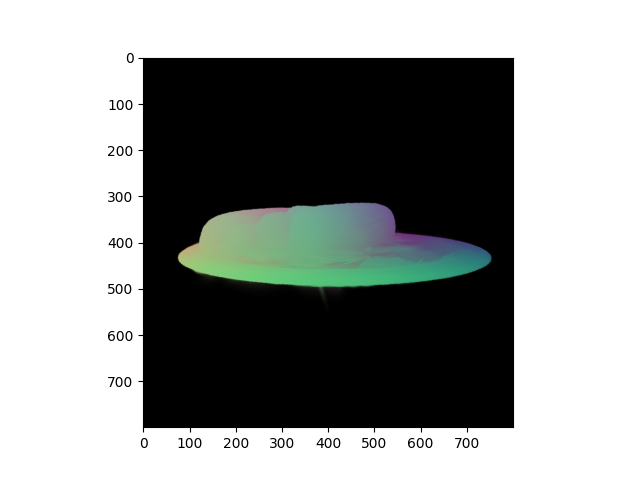

In [24]:

# Sample camera
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
gaussians_opt._scaling.data /=  1.1





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

gaussians_opt._scaling.data *=  1.1


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()



In [189]:
gaussians_opt._scaling.data *=  1.1

In [25]:
def calculate_ema(values, alpha=0.01):
    ema = [values[0]]  # Initial value is the same as the first value in the list

    for i in range(1, len(values)):
        ema.append(alpha * values[i] + (1 - alpha) * ema[-1])

    return ema


def l1_loss(network_output, gt):
    return torch.abs((network_output - gt)).mean()


def tv_loss(img):
    return 0.5 * (torch.abs(img[..., 1:, :] - img[..., :-1, :]).mean() +
                  torch.abs(img[..., :, 1:] - img[..., :, :-1]).mean())



In [26]:

def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns
    
def get_style_patch_descriptors_loss(clusters_to_opt_list, nns_indices, target_descriptor_cluster):
    """
    For every cluster of points in the clusters_to_opt_list we compute its descriptor of spatial 
    positions between all pairs of points within this cluster. Afterwards we compare this descriptor
    with the target descriptor.
    """
    loss_local_descriptor_list = []
    loss = 0.
    for cluster_points in clusters_to_opt_list:
        descriptor_points = get_descriptors(X=cluster_points, X_nns_indices=nns_indices)
        loss_local_descriptor = torch.mean(torch.square(descriptor_points - target_descriptor_cluster))
        loss += loss_local_descriptor 
        loss_local_descriptor_list.append(loss_local_descriptor)

    return loss / len(clusters_to_opt_list)


# now find initial desctiptors 

num_nns = 200
kth_nn = 20

num_nns = 50
kth_nn = 2
num_nns_local = 100 # was 100
kth_nn_local = 1

distances = torch.cdist(gaussians_opt._xyz.data[:N], gaussians_opt._xyz.data[:N])
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)

nns_indices = nns_indices[:, ::kth_nn]

target_descriptor_cluster = get_descriptors(X=gaussians_opt._xyz.data[:N], 
                                            X_nns_indices=nns_indices)
target_descriptor_cluster = target_descriptor_cluster.clone().detach()
target_descriptor_cluster.shape

torch.Size([9924, 24])

In [27]:


get_style_patch_descriptors_loss(clusters_to_opt_list=[gaussians_opt._xyz[:N]],
                                 nns_indices=nns_indices,
                                 target_descriptor_cluster=target_descriptor_cluster)



tensor(0., device='cuda:0', grad_fn=<DivBackward0>)

In [28]:
losses_full=[]
losses_pixel = []
losses_reg = []
losses_tv = []
losses_loc_descr = []


gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4


gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False


In [158]:
# optimizer = torch.optim.Adam([gaussians_opt._xyz, colors], lr=1e0)

In [29]:

# Random sampling viewpoint



# def loss_to_depth_target(d, d_trg):
#     return torch.mean(torch.square(d - d_trg) * (d_trg>0.5))

def loss_to_depth_target(d, d_trg):
    return torch.mean(torch.square(d - d_trg))


from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(31, 31), sigma=(30., 30.))


def loss_to_depth_target(d, d_trg, make_BG_large=False, blur_depth=False, blr_sgm=1.):
    d_ = d
    d_trg_ = d_trg
    if make_BG_large:
        d_trg_ = d_trg_ + (d_trg_<1e-2) * 1e2
    if blur_depth:
        d_ = gaussian_filter_2d(d_, sigma=blr_sgm)
        d_trg_ = gaussian_filter_2d(d_trg_, sigma=blr_sgm)
    return torch.mean(torch.square(d_ - d_trg_))# * (d_trg>0.01))

def renorm_cluster(cluster):
    """
    Provided a cluster of coordinates center it and normalize
    """
    return (cluster - torch.mean(cluster, dim=-1, keepdim=True)) / torch.std(cluster, dim=-1, keepdim=True)

In [36]:

for step in tqdm(range(5001)):
    gaussians_opt.optimizer.zero_grad()
    if True:
        # Pick a random Camera
        if not viewpoint_stack:
           viewpoint_stack = scene_opt.getTrainCameras().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    # Optimization gaussians
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    # Content gaussians
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


    depth_target = depth_cont.clone().detach().to(device=device)
    loss_descriptor_local = get_style_patch_descriptors_loss(
        clusters_to_opt_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)],
        nns_indices=nns_indices,
        target_descriptor_cluster=target_descriptor_cluster)

    #loss_pixel = l1_loss(image, image_cont)
    #image_cont_sobel_filters_mask = (image_cont_sobel_filters > 0.2).float()
    loss_pixel = l1_loss(image, image_cont) 
    
    l_tv = tv_loss(image)
    l_reg = torch.mean(torch.square(gaussians_opt._xyz.unsqueeze(1) - gaussians_opt._features_dc))
    
    # loss = loss_pixel * 5e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 4e6 # was 1e4
    loss = loss_pixel * 5e0  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 4e5 # was 1e4
    # loss = loss_pixel * 5e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 4e0 # was 1e4
    loss.backward()

    gaussians_opt.optimizer.step()
    losses_full.append(float(loss.detach().cpu().numpy()))
    losses_pixel.append(float(loss_pixel.detach().cpu().numpy()))
    losses_reg.append(float(l_reg.detach().cpu().numpy()))
    losses_tv.append(float(l_tv.detach().cpu().numpy()))
    losses_loc_descr.append(float(loss_descriptor_local.detach().cpu().numpy()))



    
    if step % 100 == 0:
        print(f"l_reg:{l_reg:.7f}, loss_descriptor_local:{loss_descriptor_local:.7f},",
              f"l_tv:{l_tv:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")



/tmp/ipykernel_129630/326241393.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_reg:0.7495404, loss_descriptor_local:0.0000063, l_tv:0.0100651, loss_pixel:0.0658518, loss:10.3470917
l_reg:0.0711243, loss_descriptor_local:0.0000007, l_tv:0.0100754, loss_pixel:0.0630458, loss:1.3037953
l_reg:0.0174781, loss_descriptor_local:0.0000005, l_tv:0.0071957, loss_pixel:0.0272767, loss:0.4947131


KeyboardInterrupt: 

In [73]:

# for step in tqdm(range(5001)):
#     optimizer.zero_grad()
#     # Pick a random Camera
    
#     if not viewpoint_stack:
#         viewpoint_stack = scene_opt.getTrainCameras().copy()
    
#     # if step < 2:
#     viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
#     # Optimization gaussians
#     render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
#     image, depth= render_pkg["render"], render_pkg["depth"]
#     # Content gaussians
#     render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
#     image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

#     # Render using original colors to get the edges.
#     content_gaussians._features_dc.data = content_gaussians_features_dc_orig.clone()
#     content_gaussians._features_rest.data = content_gaussians_features_rest_orig.clone()
#     render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
#     image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

#     # Get edges
#     image_cont_sobel_filters = kornia.filters.sobel(input=image_cont.unsqueeze(0))
#     content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
#     content_gaussians._features_rest.data = content_gaussians._features_rest.data*0.
    


#     depth_target = depth_cont.clone().detach().to(device=device)
#     loss_descriptor_local = get_style_patch_descriptors_loss(
#         clusters_to_opt_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)],
#         nns_indices=nns_indices,
#         target_descriptor_cluster=target_descriptor_cluster)

#     #loss_pixel = l1_loss(image, image_cont)
#     image_cont_sobel_filters_mask = (image_cont_sobel_filters > 0.2).float()
#     loss_pixel = l1_loss(image, image_cont) + \
#         l1_loss(image*image_cont_sobel_filters_mask, image_cont*image_cont_sobel_filters_mask) *1e1
        
#     l_tv = tv_loss(image)
#     l_reg = torch.mean(torch.square(gaussians_opt._xyz.unsqueeze(1) - gaussians_opt._features_dc)) * 0.
    
#     # loss = loss_pixel * 5e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 4e6 # was 1e4
#     loss = loss_pixel * 5e0  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 4e4 # was 1e4
#     # loss = loss_pixel * 5e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 4e0 # was 1e4
#     loss.backward()

#     optimizer.step()
#     losses_full.append(float(loss.detach().cpu().numpy()))
#     losses_pixel.append(float(loss_pixel.detach().cpu().numpy()))
#     losses_reg.append(float(l_reg.detach().cpu().numpy()))
#     losses_tv.append(float(l_tv.detach().cpu().numpy()))
#     losses_loc_descr.append(float(loss_descriptor_local.detach().cpu().numpy()))



    
#     if step % 100 == 0:
#         print(f"l_reg:{l_reg:.7f}, loss_descriptor_local:{loss_descriptor_local:.7f},",
#               f"l_tv:{l_tv:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")



/tmp/ipykernel_504340/3720943213.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_reg:0.0000000, loss_descriptor_local:0.0000083, l_tv:0.0216458, loss_pixel:0.1020662, loss:0.8419408
l_reg:0.0000000, loss_descriptor_local:0.0000596, l_tv:0.0061619, loss_pixel:0.0564668, loss:2.6661730
l_reg:0.0000000, loss_descriptor_local:0.0000221, l_tv:0.0251694, loss_pixel:0.1240353, loss:1.5031353
l_reg:0.0000000, loss_descriptor_local:0.0000253, l_tv:0.0168531, loss_pixel:0.1102248, loss:1.5625436
l_reg:0.0000000, loss_descriptor_local:0.0000396, l_tv:0.0158936, loss_pixel:0.0524475, loss:1.8470757
l_reg:0.0000000, loss_descriptor_local:0.0000553, l_tv:0.0093628, loss_pixel:0.0483533, loss:2.4524634
l_reg:0.0000000, loss_descriptor_local:0.0000668, l_tv:0.0135215, loss_pixel:0.0475018, loss:2.9081287
l_reg:0.0000000, loss_descriptor_local:0.0000711, l_tv:0.0243107, loss_pixel:0.1190981, loss:3.4375665
l_reg:0.0000000, loss_descriptor_local:0.0001214, l_tv:0.0381721, loss_pixel:0.1285718, loss:5.5008407
l_reg:0.0000000, loss_descriptor_local:0.0001356, l_tv:0.0216420, loss_pi

KeyboardInterrupt: 

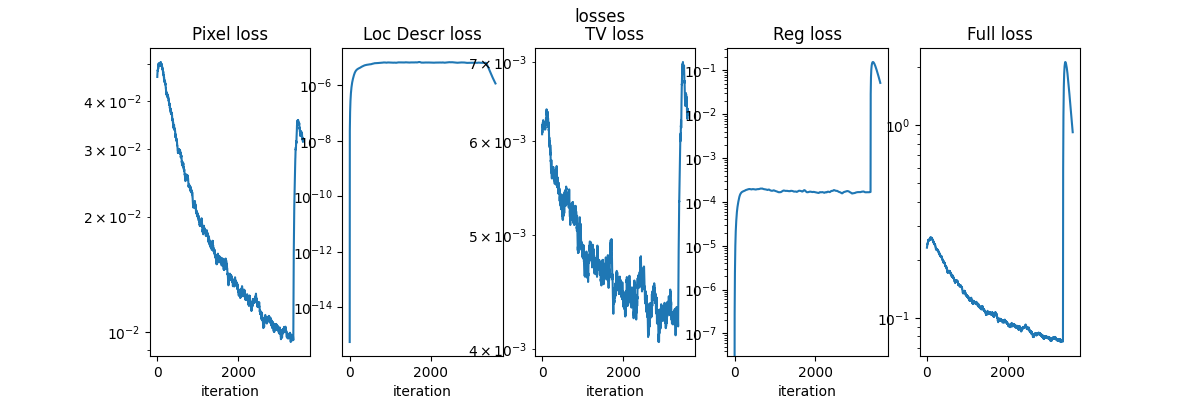

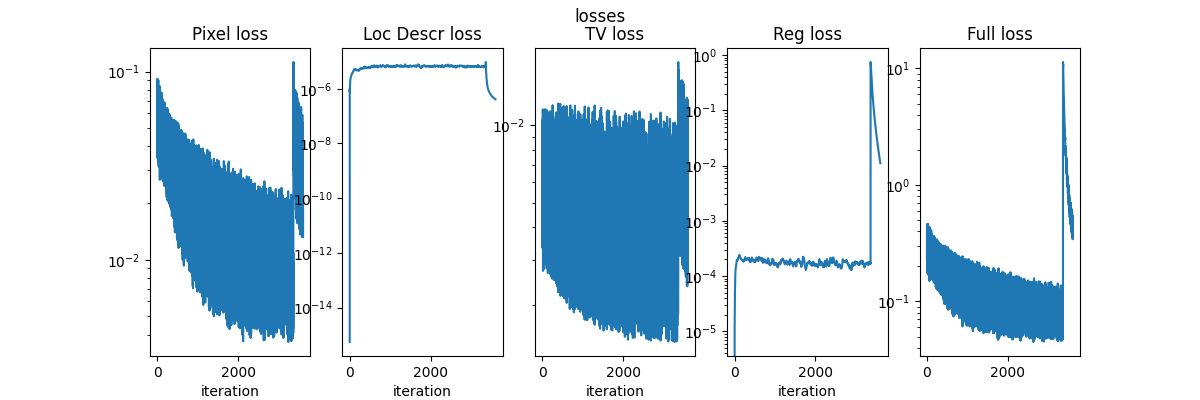

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(calculate_ema(losses_pixel))
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(calculate_ema(losses_loc_descr))
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(calculate_ema(losses_tv))
ax[2].set_yscale('log')
ax[3].set_title("Reg loss")
ax[3].plot(calculate_ema(losses_reg))
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(calculate_ema(losses_full))
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(losses_pixel)
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(losses_loc_descr)
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(losses_tv)
ax[2].set_yscale('log')
ax[3].set_title("Reg loss")
ax[3].plot(losses_reg)
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(losses_full)
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()


In [32]:
gaussians_opt_features_dc_fitted = gaussians_opt._features_dc.data.detach().clone()

In [39]:
gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()

In [204]:
gaussians_opt._scaling.data /=  1.1

In [220]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


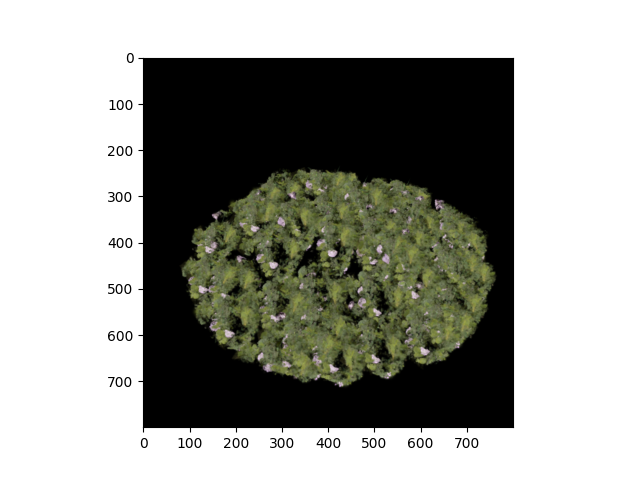

/tmp/ipykernel_129630/3967402929.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


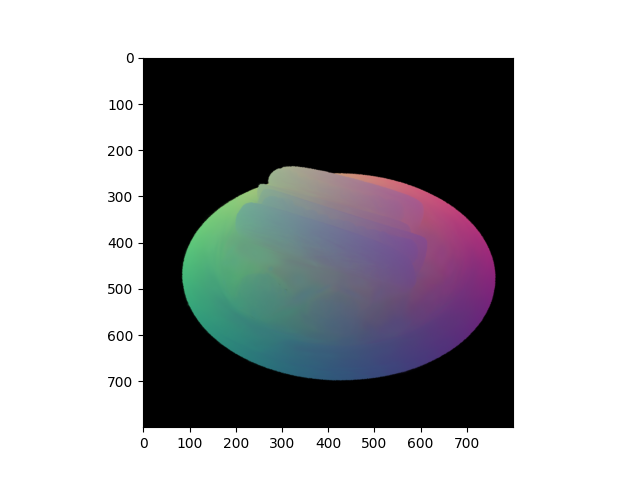

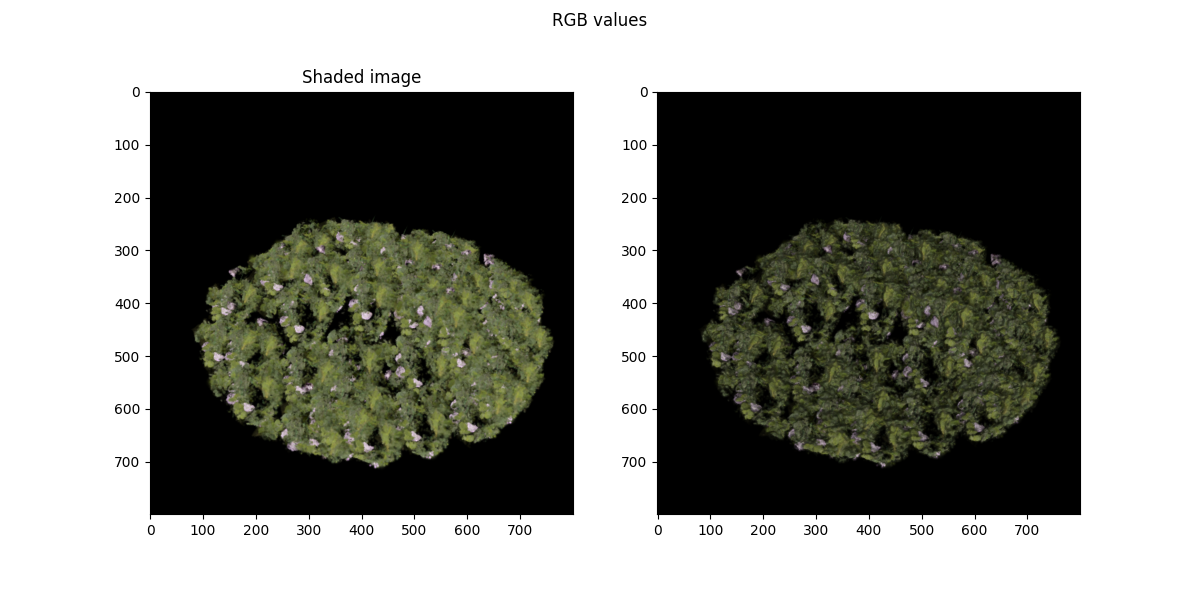

In [40]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()







scaling_for_depth_blurring = 1.1

render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, _= render_pkg["render"], render_pkg["depth"]


gaussians_opt._scaling.data /= scaling_for_depth_blurring
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
_, depth_scaled= render_pkg["render"], render_pkg["depth"]
image_shaded = shade_image_gpu(img_color=image,
                               img_depth=depth_scaled,
                          ambnt_lght=torch.tensor(np.array([.1,.1,.1])*.5, dtype=torch.float32).to(device=device),
                          drct_lght_color=torch.tensor(np.array([1., 1., 1.]), dtype=torch.float32).to(device=device),
                          drct_lght_dir =torch.tensor(np.array([-.2, -.3, 2.6]), dtype=torch.float32).to(device=device))
                          # drct_lght_dir =torch.tensor(np.array([.2, .3, 6.6]), dtype=torch.float32).to(device=device))
                               # drct_lght_dir =torch.tensor(np.array([-1.0, 2.001, 3.0001]), dtype=torch.float32).to(device=device))
gaussians_opt._scaling.data *= scaling_for_depth_blurring



gaussians_opt._scaling.data *=  SCALING_FACTOR

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("RGB values")
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
ax[0].set_title("Initial image")

image_rgb = image_shaded.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
ax[0].set_title("Shaded image")

plt.show()




In [41]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/'
MODEL_DIR_NEW = './fit_hotdog_with_rose_bush_40_clusters_v1/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))



518.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [501]:
gaussians_opt._features_dc

tensor([[[-0.5694, -0.7657, -0.0575]],

        [[-0.5683, -1.0562, -0.0754]],

        [[-0.6130, -0.9372, -0.0655]],

        ...,

        [[ 0.0619,  0.7472, -0.0019]],

        [[ 0.0976,  0.5836,  0.1385]],

        [[-0.0707,  0.6262,  0.0329]]], device='cuda:0', requires_grad=True)

In [368]:
colors

tensor([[ 0.0421,  0.0317,  0.1109],
        [-0.1124,  0.1369, -0.0471],
        [-0.0670, -0.0577, -0.0284],
        [ 0.0760,  0.2058,  0.1313],
        [-0.1200, -0.0236,  0.2474],
        [-0.0379,  0.0967, -0.0876],
        [ 0.1697,  0.2136,  0.1887],
        [-0.0243, -0.0521, -0.0524],
        [ 0.2565,  0.0865,  0.0312],
        [ 0.1003,  0.0103,  0.0495],
        [ 0.2169,  0.1303, -0.1246],
        [ 0.1257, -0.0766,  0.1800],
        [-0.0625,  0.0849, -0.1351],
        [ 0.0455, -0.0387,  0.0843],
        [-0.0930,  0.0059,  0.0136],
        [ 0.0512, -0.1633, -0.0952],
        [-0.0430, -0.1494,  0.1332],
        [-0.0269,  0.0384,  0.0310],
        [ 0.0143,  0.0274,  0.0287],
        [ 0.1564, -0.0040,  0.0181],
        [ 0.0624, -0.0423,  0.0892],
        [ 0.0278,  0.1469, -0.1039],
        [-0.2147,  0.0905, -0.0286],
        [ 0.0103,  0.0144,  0.0739],
        [-0.0438,  0.0380, -0.0477],
        [-0.1070,  0.0462,  0.1283],
        [-0.0273,  0.1693,  0.0266],
 

In [208]:
gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.

In [313]:
gaussians_opt_features_dc_original.data

tensor([[[ 0.6640,  0.3750, -0.1996]],

        [[ 1.4526,  1.1696,  0.6101]],

        [[ 1.3919,  1.1112,  0.5335]],

        ...,

        [[ 1.0514,  0.7312,  0.1031]],

        [[ 1.2187,  0.9756,  0.4335]],

        [[ 1.0862,  0.7459,  0.1637]]], device='cuda:0')

In [502]:
with torch.no_grad():
    colors = torch.nn.Parameter(torch.randn((C,3), dtype=torch.float32), requires_grad=True).to(device=device) / 1e1
    colors_gaussians = torch.concat([torch.stack([x]*N, dim=0) for x in colors], dim=0).unsqueeze(1).to(device=device)
    #gaussians_opt._features_dc.data = gaussians_opt._features_dc.data + colors_gaussians.data
    
    gaussians_opt._features_dc = gaussians_opt_features_dc_original.clone()  + colors_gaussians
    gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


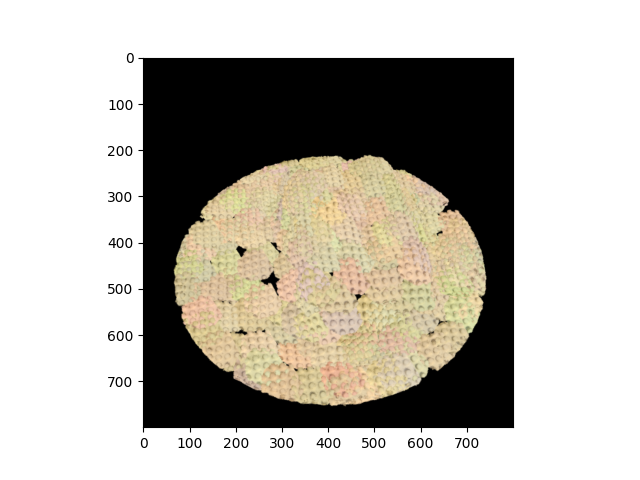

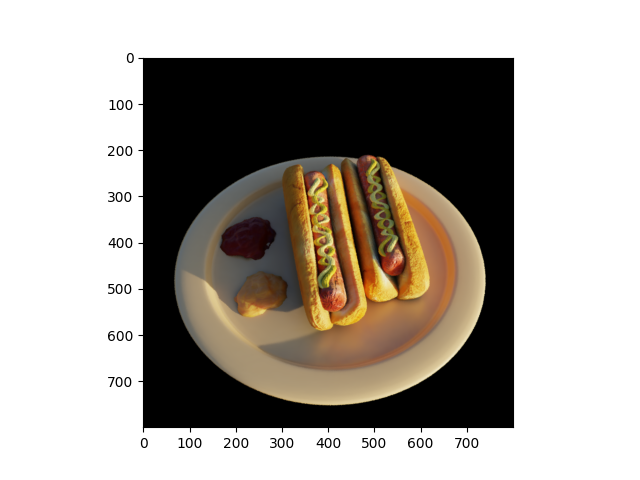

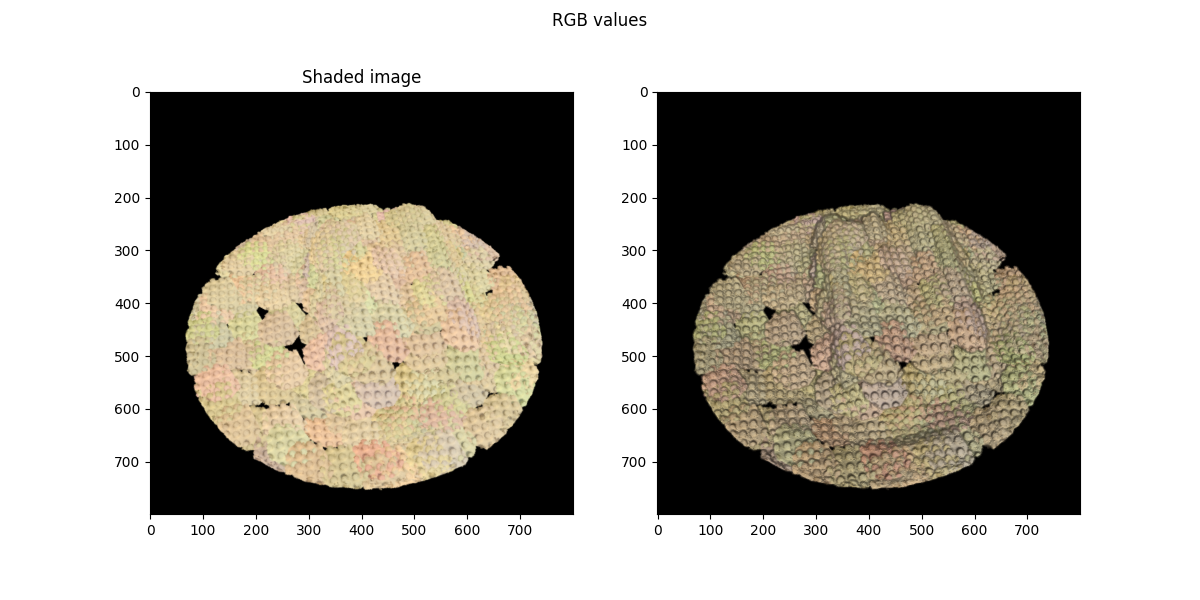

In [503]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()







scaling_for_depth_blurring = 1.1

render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, _= render_pkg["render"], render_pkg["depth"]


gaussians_opt._scaling.data /= scaling_for_depth_blurring
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
_, depth_scaled= render_pkg["render"], render_pkg["depth"]
image_shaded = shade_image_gpu(img_color=image,
                               img_depth=depth_scaled,
                          ambnt_lght=torch.tensor(np.array([.1,.1,.1])*.5, dtype=torch.float32).to(device=device),
                          drct_lght_color=torch.tensor(np.array([1., 1., 1.]), dtype=torch.float32).to(device=device),
                          drct_lght_dir =torch.tensor(np.array([-.2, -.3, 2.6]), dtype=torch.float32).to(device=device))
                          # drct_lght_dir =torch.tensor(np.array([.2, .3, 6.6]), dtype=torch.float32).to(device=device))
                               # drct_lght_dir =torch.tensor(np.array([-1.0, 2.001, 3.0001]), dtype=torch.float32).to(device=device))
gaussians_opt._scaling.data *= scaling_for_depth_blurring



gaussians_opt._scaling.data *=  SCALING_FACTOR

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("RGB values")
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
ax[0].set_title("Initial image")

image_rgb = image_shaded.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
ax[0].set_title("Shaded image")

plt.show()




In [409]:
gaussians_opt._features_dc.data.shape, N, C

(torch.Size([542800, 1, 3]), 2714, 200)

In [419]:
torch.mean(reg_loss)

tensor(0.3290, device='cuda:0')

# Now optimize for colors

In [438]:
content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog/chkpnt30000.pth")[0], opt)
gaussians_opt.restore(torch.load("./fit_hotdog_with_lego_200_clusters_v1/chkpnt1.pth")[0], opt)

In [504]:
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False

In [505]:
# optimizer_color = torch.optim.Adam([gaussians_opt._features_dc, gaussians_opt._features_rest], lr=1e-2)
optimizer_color = torch.optim.Adam([gaussians_opt._features_dc], lr=1e-2)
# optimizer_color = torch.optim.Adam([colors], lr=1e-2)

losses_color = []
losses_color_reg = []

In [506]:


for step in tqdm(range(5001)):
    optimizer_color.zero_grad()
    if True:
        # Pick a random Camera
        if not viewpoint_stack:
           viewpoint_stack = scene_opt.getTrainCameras().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    # Optimization gaussians
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    # Content gaussians
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


    colors_reshaped = torch.reshape(gaussians_opt._features_dc, (C, N, 1, 3))
    loss_color_reg = torch.mean(torch.std(colors_reshaped, dim=1))
    # loss_color_reg = torch.mean(torch.square(colors_reshaped))

    loss_rgb = l1_loss(image, image_cont)  
    
    loss = loss_rgb + loss_color_reg * 1e-1
    loss.backward()

    optimizer_color.step()
    losses_color.append(float(loss_rgb.detach().cpu().numpy()))
    losses_color_reg.append(float(loss_color_reg.detach().cpu().numpy()))



    
    if step % 100 == 0:
        print(f"loss_rgb:{loss_rgb:.7f}, losses_color_reg:{loss_color_reg:.7f}")



/tmp/ipykernel_504340/2404923381.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

loss_rgb:0.0692179, losses_color_reg:0.3290335
loss_rgb:0.0520716, losses_color_reg:0.0500682
loss_rgb:0.0206022, losses_color_reg:0.0327017
loss_rgb:0.0413898, losses_color_reg:0.0386165
loss_rgb:0.0248415, losses_color_reg:0.0425639
loss_rgb:0.0378131, losses_color_reg:0.0466030
loss_rgb:0.0155518, losses_color_reg:0.0446885
loss_rgb:0.0151360, losses_color_reg:0.0435578
loss_rgb:0.0199742, losses_color_reg:0.0458813
loss_rgb:0.0196622, losses_color_reg:0.0482206
loss_rgb:0.0164851, losses_color_reg:0.0457400
loss_rgb:0.0195741, losses_color_reg:0.0449530
loss_rgb:0.0260952, losses_color_reg:0.0463835
loss_rgb:0.0250223, losses_color_reg:0.0521987
loss_rgb:0.0200438, losses_color_reg:0.0466716
loss_rgb:0.0282439, losses_color_reg:0.0455452


KeyboardInterrupt: 

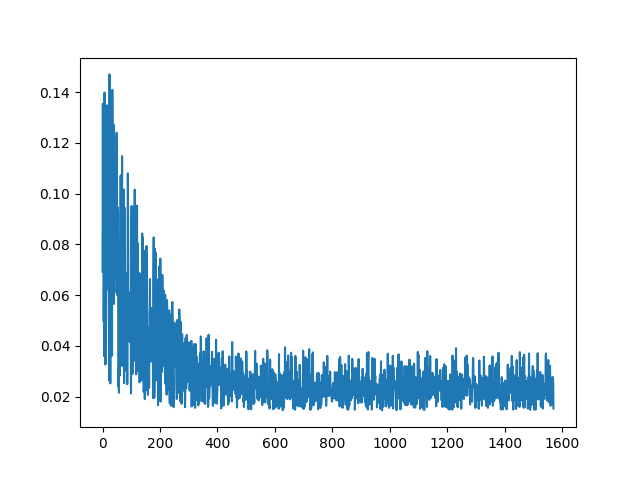

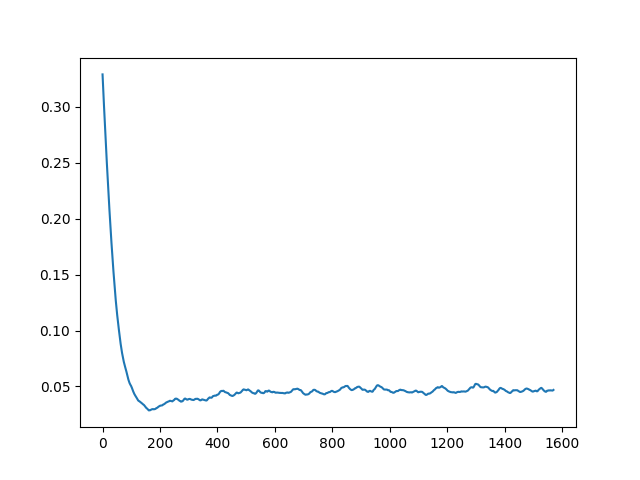

In [507]:
plt.figure()
plt.plot(losses_color)
plt.show()

plt.figure()
plt.plot(losses_color_reg)
plt.show()

In [509]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

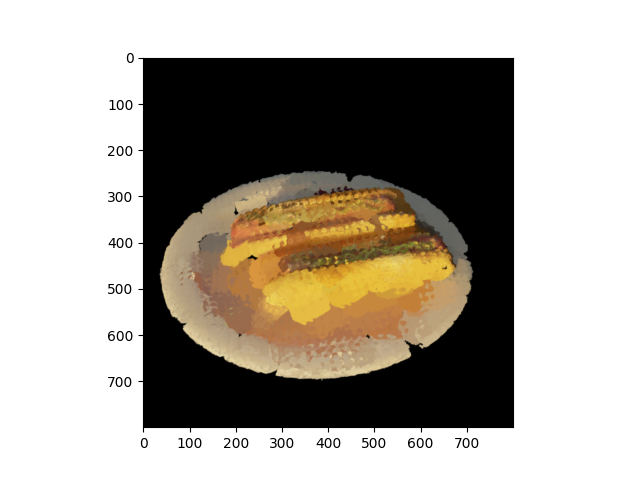

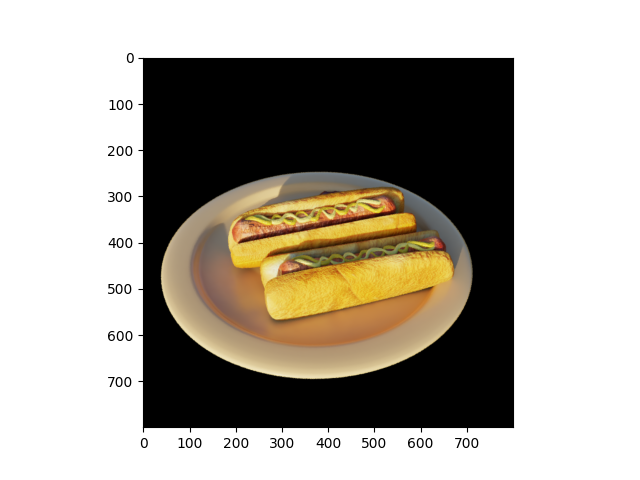

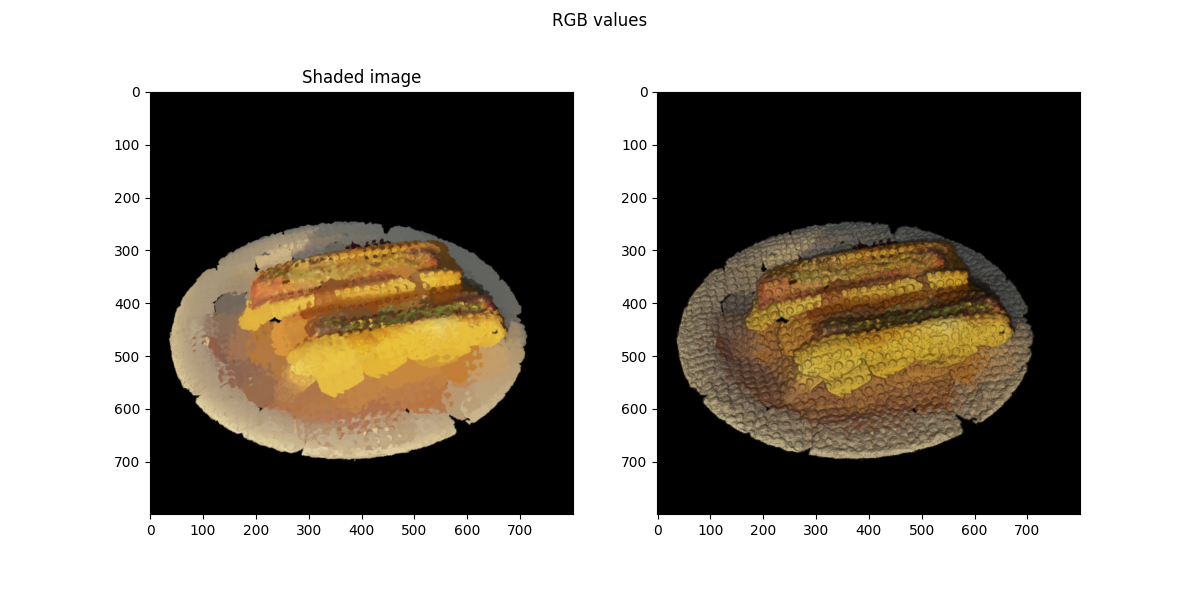

In [510]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()







scaling_for_depth_blurring = 1.1

render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, _= render_pkg["render"], render_pkg["depth"]


gaussians_opt._scaling.data /= scaling_for_depth_blurring
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
_, depth_scaled= render_pkg["render"], render_pkg["depth"]
image_shaded = shade_image_gpu(img_color=image,
                               img_depth=depth_scaled,
                          ambnt_lght=torch.tensor(np.array([.1,.1,.1])*.5, dtype=torch.float32).to(device=device),
                          drct_lght_color=torch.tensor(np.array([1., 1., 1.]), dtype=torch.float32).to(device=device),
                          drct_lght_dir =torch.tensor(np.array([-.2, -.3, 2.6]), dtype=torch.float32).to(device=device))
                          # drct_lght_dir =torch.tensor(np.array([.2, .3, 6.6]), dtype=torch.float32).to(device=device))
                               # drct_lght_dir =torch.tensor(np.array([-1.0, 2.001, 3.0001]), dtype=torch.float32).to(device=device))
gaussians_opt._scaling.data *= scaling_for_depth_blurring



gaussians_opt._scaling.data *=  SCALING_FACTOR

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("RGB values")
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
ax[0].set_title("Initial image")

image_rgb = image_shaded.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
ax[0].set_title("Shaded image")

plt.show()




In [511]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/'
MODEL_DIR_NEW = './fit_hotdog_with_lego_200_clusters_v2_colored/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))



In [302]:
losses_color = []

gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4


gaussians_opt._xyz.requires_grad = False
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False

In [303]:

for step in tqdm(range(5001)):
    gaussians_opt.optimizer.zero_grad()
    if True:
        # Pick a random Camera
        if not viewpoint_stack:
           viewpoint_stack = scene_opt.getTrainCameras().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    # Optimization gaussians
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    # Content gaussians
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


    loss_rgb = l1_loss(image, image_cont) 
    
    loss = loss_rgb
    loss.backward()

    gaussians_opt.optimizer.step()
    losses_color.append(float(loss_rgb.detach().cpu().numpy()))



    
    if step % 100 == 0:
        print(f"loss_rgb:{loss_rgb:.7f}")



/tmp/ipykernel_504340/3201841820.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

loss_rgb:0.1401907
loss_rgb:0.0503510
loss_rgb:0.0332035
loss_rgb:0.0345448
loss_rgb:0.0357986
loss_rgb:0.0328486
loss_rgb:0.0171343
loss_rgb:0.0235408
loss_rgb:0.0434037
loss_rgb:0.0345820
loss_rgb:0.0141803
loss_rgb:0.0244571
loss_rgb:0.0143464


KeyboardInterrupt: 

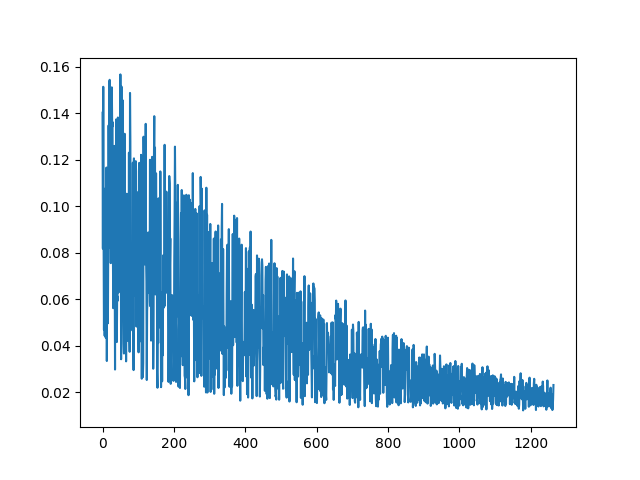

In [304]:
plt.figure()
plt.plot(losses_color)
plt.show()

In [310]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


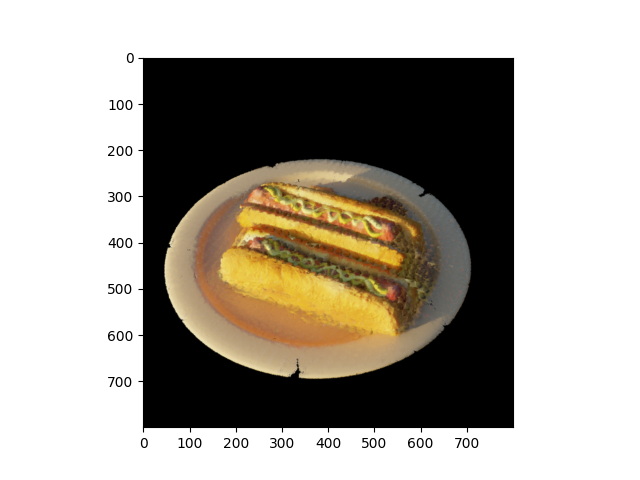

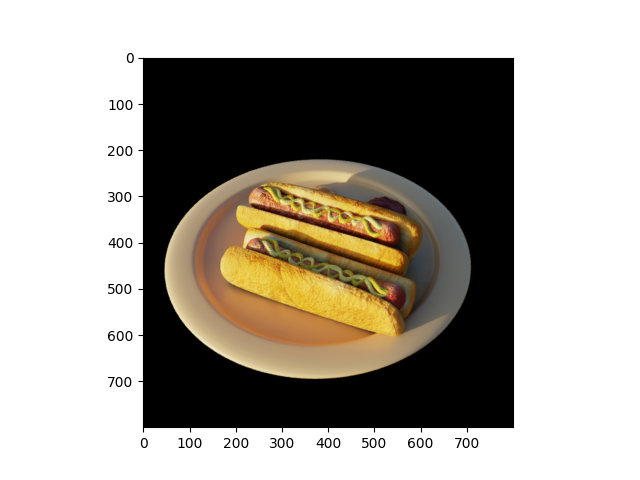

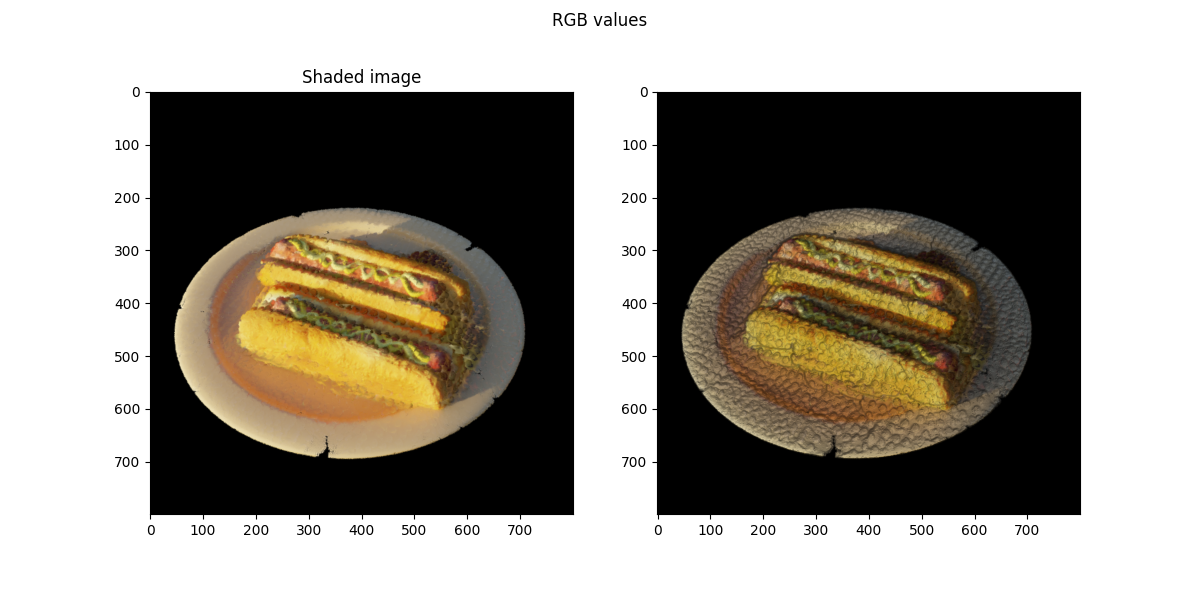

In [311]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()







scaling_for_depth_blurring = 1.1

render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, _= render_pkg["render"], render_pkg["depth"]


gaussians_opt._scaling.data /= scaling_for_depth_blurring
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
_, depth_scaled= render_pkg["render"], render_pkg["depth"]
image_shaded = shade_image_gpu(img_color=image,
                               img_depth=depth_scaled,
                          ambnt_lght=torch.tensor(np.array([.1,.1,.1])*.5, dtype=torch.float32).to(device=device),
                          drct_lght_color=torch.tensor(np.array([1., 1., 1.]), dtype=torch.float32).to(device=device),
                          drct_lght_dir =torch.tensor(np.array([-.2, -.3, 2.6]), dtype=torch.float32).to(device=device))
                          # drct_lght_dir =torch.tensor(np.array([.2, .3, 6.6]), dtype=torch.float32).to(device=device))
                               # drct_lght_dir =torch.tensor(np.array([-1.0, 2.001, 3.0001]), dtype=torch.float32).to(device=device))
gaussians_opt._scaling.data *= scaling_for_depth_blurring



gaussians_opt._scaling.data *=  SCALING_FACTOR

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("RGB values")
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
ax[0].set_title("Initial image")

image_rgb = image_shaded.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
ax[0].set_title("Shaded image")

plt.show()


